Попробуем решить уравнение $-\dfrac{\partial^2u}{\partial y^2} - \dfrac{\partial^2 u}{\partial x^2} + \left(\dfrac{\partial u}{\partial y}\right)^2 = 10 xy$ в квадрате [0, 1]$\times$[0, 1] с начальными условиями $u(x, 0) = \sin{\pi x}$, $u(x,1) = -2x(x-1)$,  $u(1,y) = u(0,y) = 0$

Уравнение в слабой форме получается таким (нужно учесть, что $u = 0$ на границах $x= \{0,1\}$, поэтому нет дополнительных слагаемых при интегрировании по частям):

$$
\int \left(\dfrac{\partial u}{\partial y}\dfrac{\partial v}{\partial y}+u\dfrac{\partial u}{\partial x}\dfrac{\partial v}{\partial x}+\left(\dfrac{\partial u}{\partial x}\right)^2v+\left(\dfrac{\partial u}{\partial y}\right)^2v\right)d^2r = \int fvd^2r
$$

# Загрузка fenics

In [ ]:
# Данный код протестирован только в Google Colab
# Уточните, как устанавливать FEniCS на вашу систему

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl_legacy
    import dolfin
else:
    try:
        import ufl_legacy
        import dolfin
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
        import ufl_legacy
        import dolfin


--2025-05-09 22:19:58--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.110.153, 185.199.111.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-05-09 22:19:58 (32.2 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/a51d633e/releases/pybi

# Полезный код

In [ ]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
N_ELEMENTS = 50
mesh = fe.UnitSquareMesh(N_ELEMENTS, N_ELEMENTS) #Определяем сетку на которой будем искать решение

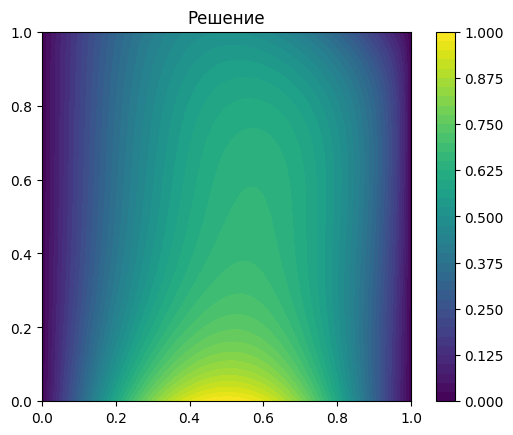

In [ ]:
lagr_polinomial_second_order = fe.FunctionSpace(
        mesh,
        "Lagrange",
        2,
)#Определяем пространство функций. Оно общее для тестовых функций и для нашего приближенного решения.
tol = 1e-6

#Эта функция нужна для скрытых методов сетки. on_boundary булева переменная,
#которая приходит из автоматической проверки точки на принедлежность границе.
#можно переписать функию и не использовать on_boundary.
# Определение граничных условий


# Определение граничных условий
class LowerBoundary(fe.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fe.near(x[1], 0, tol)

class UpperBoundary(fe.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary  and fe.near(x[1], 1, tol)

class LeftBoundary(fe.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary  and fe.near(x[0], 0, tol)

class RightBoundary(fe.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary  and fe.near(x[0], 1, tol)

# Инициализация границ
lower_bc = LowerBoundary()
upper_bc = UpperBoundary()
left_bc = LeftBoundary()
right_bc = RightBoundary()

# Функции граничных условий
u_bottom = fe.Expression("sin(pi*x[0])", pi=np.pi, degree=3)
u_top = fe.Expression("-2*x[0]*(x[0]-1)", degree=2)
u_zero = fe.Constant(0.0)

# Создание объектов граничных условий
bc_bottom = fe.DirichletBC(lagr_polinomial_second_order, u_bottom, lower_bc)
bc_top = fe.DirichletBC(lagr_polinomial_second_order, u_top, upper_bc)
bc_left = fe.DirichletBC(lagr_polinomial_second_order, u_zero, left_bc)
bc_right = fe.DirichletBC(lagr_polinomial_second_order, u_zero, right_bc)

# Собираем все условия в список
bcs = [bc_bottom, bc_top, bc_left, bc_right]

x = fe.SpatialCoordinate(mesh)

#задаем функции для составления основного уравнения

u = fe.Function(lagr_polinomial_second_order)  # неизвестная функция
v = fe.TestFunction(lagr_polinomial_second_order)
f = fe.Expression("10*x[0]*x[1]", degree=2)
u_solution = fe.Function(lagr_polinomial_second_order)


#составим уравнение
A = (u.dx(1)*v.dx(1) + u*u.dx(0)*v.dx(0) + ((u.dx(0))**2 + (u.dx(1))**2)*v - f*v)*fe.dx
# L = f * v * fe.dx


# Автоматическое вычисление якобиана
J = fe.derivative(A, u)

# Создание и решение нелинейной задачи
problem = fe.NonlinearVariationalProblem(A, u, bcs, J)
solver = fe.NonlinearVariationalSolver(problem)
pl = fe.plot(u_solution)
solver.solve()

# Визуализация
fe.plot(u, title="Решение")
plt.colorbar(fe.plot(u))
plt.show()

